## VCF 파일을 DataFrame으로 전환
최종적으로 vcf 파일은 원하는 정보를 추출하기 위해 python의 DataFrame으로 변환하여 사용한다. 여기서는 우리가 vcf 파일을 데이터프레임으로 전환하는데에 있어서 어떠한 전략을 사용할지에 대해서 논한다.

In [33]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import sys
import vcf
import os
import re
import json
import math
%matplotlib inline

최종적으로 annotation을 마친 vcf 파일을 읽어 들이며 이때 주석부분 (skiprows)은 제외하고 1샘플이 존재함으로 총 10개의 컬럼을 읽어들인다.

In [16]:
ngene_df=pd.read_table("HCT-15_final.vcf", skiprows=494,header=0,usecols=range(10))
vcf_reader=vcf.Reader(open("HCT-15_final.vcf",'r'))
sample_name=vcf_reader.samples[0]

## INFO 필드 파싱하기
CHROM, POS, ID, REF, ALT, QUAL, FILTER, INFO, FORMAT, 샘플의 10개의 컬럼을 가진 데이터프레임이 생성된다. 여기서 주의해야 할 것은 INFO 컬럼으로 key1=value1;key2=value2...의 형식으로 데이터가 저장된다.

In [17]:
ngene_df.head()

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,HCT-15
0,chr13,32890572,rs1799943;U43746.1:c.-26G>A,G,A,15619.80,.,AB=0.488384;ABP=5.22993;freebayes_AC=1;AFF=0.5...,GT:DP:DPR:RO:QR:AO:QA:GL,"0/1:1894:1894,925:968:25773:925:26830:-1844.59..."
1,chr13,32899388,rs11571610;U43746.1:c.425+67A>C,A,C,5520.29,.,AB=0.479391;ABP=7.12754;freebayes_AC=1;AFF=0.5...,GT:DP:DPR:RO:QR:AO:QA:GL,"0/1:1116:1116,535:581:17398:535:11733:-720.137..."
2,chr13,32906980,rs1801439;U43746.1:c.1365A>G,A,G,3432.77,.,AB=0.498611;ABP=3.02236;freebayes_AC=1;AFF=0.5...,GT:DP:DPR:RO:QR:AO:QA:GL,"0/1:720:720,359:361:10879:359:7266:-437.374,0,..."
3,chr13,32907075,.,C,T,7405.49,.,AB=0.322771;ABP=511.009;freebayes_AC=1;AFF=0.5...,GT:DP:DPR:RO:QR:AO:QA:GL,"0/1:1862:1862,601:1259:38451:601:17029:-972.48..."
4,chr13,32907535,.,CTTTTTTTTTTTG,CTTTTTTTTTG,13160.50,.,AB=0.471519;ABP=16.369;freebayes_AC=1;AFF=0.5;...,GT:DP:DPR:RO:QR:AO:QA:GL,"0/1:1896:1896,894:488:14177:894:22619:-1618.95..."


#### SNPEff 데이터 파싱
Annotation은 vcf파서를 활용하여 vcf 파일의 info 필드와 info 필드내의 snpeff의 annotation 결과가 있는 ANN 키를 분리한다. ANN 부분은 transcript 별로 annotation된 내용이 저장되는데 각 transcript는 콤마(,)로 구분된 16개의 필드가 '|'로 구분된다.

In [5]:
info=[]
ann=[]
for record in vcf_reader:
    #print record.INFO['RSPOS']
    vcf_rec=record.INFO
    vcf_rec['CHROM']=record.CHROM
    vcf_rec['POS']=record.POS
    vcf_rec['ID']=record.ID
    vcf_rec['REF']=record.REF
    vcf_rec['ALT']=record.ALT
    vcf_rec['QUAL']=record.QUAL
    vcf_rec['FILTER']=record.FILTER
    
    vcf_info_ann=','.join(record.INFO['ANN'])
    
    ann.append(vcf_info_ann)
    
    info.append(vcf_rec)

SNPEff의 정보가 포함된 ann_df 데이터프레임을 생성한다.

In [38]:
ann_df=pd.DataFrame(ann)
ann_df.columns=['snpeff']
info_c_df=ann_df["snpeff"].str.split(',').apply(pd.Series,1).stack()

In [39]:
ann_df.head()

,snpeff
0,A|5_prime_UTR_variant|MODIFIER|BRCA2|BRCA2|tra...
1,C|intron_variant|MODIFIER|BRCA2|BRCA2|transcri...
2,G|synonymous_variant|LOW|BRCA2|BRCA2|transcrip...
3,T|missense_variant|MODERATE|BRCA2|BRCA2|transc...
4,CTTTTTTTTTG|intron_variant|MODIFIER|BRCA2|BRCA...


데이터프레임 ann_df는 transcript 별로 ','로 구분되어 있기 때문에 transcript별로 다시 분할하고 '|'로 구분한다. 최종적으로 SNPEff의 결과만을 저장하는 detail_info_df  데이터프레임이 생성된다.

In [40]:
detail_info_df=info_c_df.apply(lambda x: pd.Series(x.split('|')))
detail_info_df.columns=['Allele','Effect','Putative_impact','Gene_name','Gene_id','Feature_type','Feature_id','Tracscript_biotype','Rank_total','HGVS.c','HGVS.p','cDNA_position','CDS_position','Protein_position','Distance_to_feature','Errors']
detail_info_df.head()

Allele                 Effect Putative_impact Gene_name Gene_id  \
0 0      A    5_prime_UTR_variant        MODIFIER     BRCA2   BRCA2   
  1      A  upstream_gene_variant        MODIFIER     ZAR1L   ZAR1L   
1 0      C         intron_variant        MODIFIER     BRCA2   BRCA2   
2 0      G     synonymous_variant             LOW     BRCA2   BRCA2   
3 0      T       missense_variant        MODERATE     BRCA2   BRCA2   

    Feature_type      Feature_id Tracscript_biotype Rank_total       HGVS.c  \
0 0   transcript     NM_000059.3     protein_coding       2/27     c.-26G>A   
  1   transcript  NM_001136571.1     protein_coding              c.-4510C>T   
1 0   transcript     NM_000059.3     protein_coding       4/26  c.425+67A>C   
2 0   transcript     NM_000059.3     protein_coding      10/27    c.1365A>G   
3 0   transcript     NM_000059.3     protein_coding      10/27    c.1460C>T   

          HGVS.p cDNA_position CDS_position Protein_position  \
0 0                                                            
  1                                                            
1 0                                                            
2 0  p.Ser455Ser    1592/11386   1365/10257         455/3418   
3 0  p.Ala487Val    1687/11386   1460/10257         487/3418   

    Distance_to_feature Errors  
0 0                  26         
  1                4481         
1 0                             
2 0                             
3 0

In [41]:
detail_info_df.index=detail_info_df.index.droplevel(-1)
detail_info_df.head()

,Allele,Effect,Putative_impact,Gene_name,Gene_id,Feature_type,Feature_id,Tracscript_biotype,Rank_total,HGVS.c,HGVS.p,cDNA_position,CDS_position,Protein_position,Distance_to_feature,Errors
0,A,5_prime_UTR_variant,MODIFIER,BRCA2,BRCA2,transcript,NM_000059.3,protein_coding,2/27,c.-26G>A,,,,,26,
0,A,upstream_gene_variant,MODIFIER,ZAR1L,ZAR1L,transcript,NM_001136571.1,protein_coding,,c.-4510C>T,,,,,4481,
1,C,intron_variant,MODIFIER,BRCA2,BRCA2,transcript,NM_000059.3,protein_coding,4/26,c.425+67A>C,,,,,,
2,G,synonymous_variant,LOW,BRCA2,BRCA2,transcript,NM_000059.3,protein_coding,10/27,c.1365A>G,p.Ser455Ser,1592/11386,1365/10257,455/3418,,
3,T,missense_variant,MODERATE,BRCA2,BRCA2,transcript,NM_000059.3,protein_coding,10/27,c.1460C>T,p.Ala487Val,1687/11386,1460/10257,487/3418,,


#### INFO 필드 파싱
info 필드의 모든 내용을 info_a_df 데이터프레임에 저장한다.

In [19]:
info_a_df=pd.DataFrame(info)
info_a_df.head()

,1KG_AF,1kg_AC,1kg_AN,AA,AA_AC,AA_GTC,AB,ABP,AC_AFR,AC_AMR,...,exac_AN,freebayes_AC,freebayes_AN,kor2678_Alt,kor2678_AltCnt,kor2678_AltFreq,kor2678_NumSampleAlleles,kor2678_RefCnt,kor2678_RefFreq,technology.illumina
0,0.209265,1048.0,5008.0,G|||,"[452, 3954]","[19, 414, 1770]",0.488384,5.22993,1016.0,2171.0,...,121406.0,1,2,1.0,1005.0,0.37528,2678.0,1673.0,0.62472,1.0
1,0.074281,372.0,5008.0,A|||,NaN,NaN,0.479391,7.12754,NaN,NaN,...,NaN,1,2,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,0.073682,369.0,5008.0,A|||,"[87, 4315]","[0, 87, 2114]",0.498611,3.02236,236.0,769.0,...,121406.0,1,2,1.0,330.0,0.12323,2678.0,2348.0,0.87677,1.0
3,NaN,NaN,NaN,NaN,NaN,NaN,0.322771,511.00900,NaN,NaN,...,NaN,1,2,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,NaN,NaN,NaN,NaN,NaN,NaN,0.471519,16.36900,NaN,NaN,...,NaN,1,2,NaN,NaN,NaN,NaN,NaN,NaN,1.0


### 최종 INFO 필드 파싱 내용 저장하기

In [9]:
#com_df=ngene_df.join(info_a_df)
combine_df=info_a_df.join(detail_info_df)

In [20]:
combine_df.head()

,1KG_AF,1kg_AC,1kg_AN,AA,AA_AC,AA_GTC,AB,ABP,AC_AFR,AC_AMR,...,Feature_id,Tracscript_biotype,Rank_total,HGVS.c,HGVS.p,cDNA_position,CDS_position,Protein_position,Distance_to_feature,Errors
0,0.209265,1048.0,5008.0,G|||,"[452, 3954]","[19, 414, 1770]",0.488384,5.22993,1016.0,2171.0,...,NM_000059.3,protein_coding,2/27,c.-26G>A,,,,,26,
0,0.209265,1048.0,5008.0,G|||,"[452, 3954]","[19, 414, 1770]",0.488384,5.22993,1016.0,2171.0,...,NM_001136571.1,protein_coding,,c.-4510C>T,,,,,4481,
1,0.074281,372.0,5008.0,A|||,NaN,NaN,0.479391,7.12754,NaN,NaN,...,NM_000059.3,protein_coding,4/26,c.425+67A>C,,,,,,
2,0.073682,369.0,5008.0,A|||,"[87, 4315]","[0, 87, 2114]",0.498611,3.02236,236.0,769.0,...,NM_000059.3,protein_coding,10/27,c.1365A>G,p.Ser455Ser,1592/11386,1365/10257,455/3418,,
3,NaN,NaN,NaN,NaN,NaN,NaN,0.322771,511.00900,NaN,NaN,...,NM_000059.3,protein_coding,10/27,c.1460C>T,p.Ala487Val,1687/11386,1460/10257,487/3418,,


In [42]:
col_value=list(combine_df.columns.values)
print len(col_value)
#print col_value

388


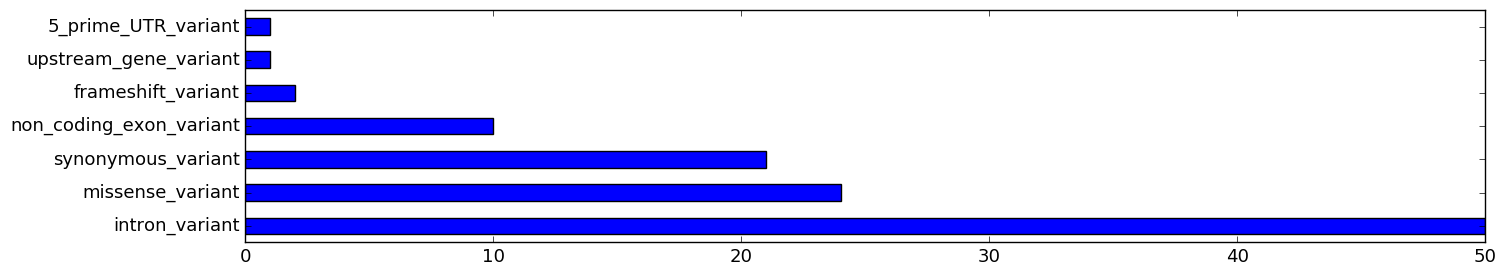

In [34]:
stat=combine_df["Effect"].value_counts()
stat.plot(kind="barh", fontsize=13, figsize=(16,3))